<h2><center>ECE 594N: Homework 3 Paper Review</center></h2>
    <h1><center> Data fitting on manifolds with composite Bézier-like curves and blended cubic splines</center></h1>
    <h2><center>by Jax Burd</center></h2>


<em>Gousenbourger, P. Y., Massart, E., & Absil, P. A. (2019). Data fitting on manifolds with composite Bézier-like curves and blended cubic splines. Journal of Mathematical Imaging and Vision, 61(5), 645-671.</em>

# Introduction
This paper proposes new techniques for fitting a curve to data that lies within a manifold. The goal is to manage the  tradeoff between the curve accurately fitting the data and the curve appearing straight. By fitting a curve to data on a manifold, it allows us to potentially interpolate data not originally given. A powerful tool when the data initially on a manifold is sparse and is not enough for some computationally demanding work it pipelines into.

### Applications

One application the paper mentions curve fitting on a manifold is useful for is during image processing of organs and other anatomical data. In particular is helps with denoising and resampling how the shapes of these organs change over time, as you can imagine the evolution these shapes lie on a manifold and only so many images can be captured over time. Another motivation is interpolating rotations of 3D objects on the manifold of SO(3), so that movement of rigid bodies can appear smooth in computer graphics. Overall, this work is important interpolation of time-dependent or parameter-dependent data on a Riemannian manifold

### Literature Review

#### Paper 1. Differentiable Piecewise-Bézier Aurfaces on Riemannian Manifolds
<em>[1] Absil, P.A., Gousenbourger, P.Y., Striewski, P., Wirth, B.: <b>Differentiable Piecewise-Bézier surfaces on Riemannian manifolds</b>. SIAMJ. Imaging Sci. 9(4), 1788–1828 (2016). https://doi.org/10.1137/ </em>

- One of Gousenbourger's previous works, one of the new techniques in this paper builds upon the composite Bezier curve interpolation method he proposed in <em>Differentiable Piecewise-Bézier Surfaces on Riemannian Manifolds</em>. Basically, which was once an interpolation method he extended it to a curve fitting method using Bezier curves.

#### Paper 2. Interpolation and Tracking of Rigid Body Orientations
<em>[27] Park, J.: Interpolation and tracking of rigid body orientations. In: ICCAS, pp. 668–673 (2010)</em>

- This paper is important because it goes in depth into one of the applications for the curve fitting model featured in this report. When wanting to interpolation data in 3D euclidean space, because of the number of degrees of freedom and the more complex nature of it than a simple planar space, interpolating graphics or 3D body orientations is in fact interpolating on a manifold.

#### Paper 3.  Geodesic Regression and the Theory of Least Squares on Riemannian manifolds
<em>[12] Fletcher, P.T.: Geodesic regression and the theory of least squares on Riemannian manifolds. Int. J. Comput. Vis. 105(2), 171–185 (2013). https://doi.org/10.1007/s11263-012-0591-y</em>

- Curve fitting aims to balance both "straightness" and "sufficiently fitting" the data. Researchers both explore the extremes of this optimization problem by focusing on only one of the two. This paper solely studies the "straightness" factor of curving fitting to data on a manifold by explaining least-squares linear regression for manifolds; aka geodesic regression.

#### Paper 4.  Fitting Smooth Paths to Spherical Data
<em>[17] Jupp, P.E., Kent, J.T.: Fitting Smooth paths to spherical data. J. Appl. Stat. 36(1), 34–46 (1987)</em>

- Some methods of curve fitting data on a manifold avoid the difficulties of working on the manifold itself by completely abstracting it from the problem. Jupp and Kent in this paper aim to transform the problem originally on the manifold onto Euclidean space using an "unwrapping and unrolling" technique, such that it can be solved usign classical methods and then projected back.

# Background & Model
Sorry Nina but I ran out of time to get to this part, but all the equations implements in my code can be pulled from section 4 of the paper.

The key thing to know is that curve fitting follows the following optimization problem with a dynamic variable lambda. The smaller lambda is the "straighter" or more conservative the curve appears. The larger lamba is the "closer to fitting the data points" or the stretch-ier the curve gets. As lamda reaches large values, Gousenbourger makes a point that his curve fitting algorithms behave as decent interpolators for data on manifolds.

# Implementation
<b>Note:</b> I intended on creating a function for both fitting a curve to manifold data using bezier curves (in Section 4) and blended cubic splines (in Section 5), which is the paper's novel work. I only could create the first method using bezier curves since I ran out of time :(

I also heavily referenced Gousenbourger's matlab code available at [https://github.com/pgousenbourg/manint].


In [8]:
# Imports
import math
import time
import numpy as np

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere

import matplotlib
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

visualization.tutorial_matplotlib()

INFO: Using numpy backend


In [11]:
def cpGenW(D,j,Tdata):
    a, b = Tdata.shape
    w = D[j]
    # w = reshape(D(j,:)),1,1,length(D(j,:)));
    w = np.broadcast_to(w,(b,a))
    w = np.transpose(w)
    
    # weighted sum
    y = sum(np.multiply(w,Tdata),0);

    return y

In [1]:
def cp_approx(manifold, dataPoints, lamda):
    l, c = [1, dataPoints.shape[1]]
    n = len(dataPoints)
    
    Nx   = 2*n                     # Number of unknowns
    Ncp  = 3*n-2                   # Number of control points at the end
    Tx  = np.zeros((l,c,Nx,n))     # Vector of unknowns in tangent spaces of all data points
    
    A = np.zeros((Nx,Nx))          #  A*x = C*data
    C = np.zeros((Nx,n))
    
    # First segment : part due to the acceleration term
    A[0,0:4] = 3*np.array([8, -12, 2, 2])
    A[1,0:4] = 3*np.array([-12, 24, -12, 0])
    A[2,0:4] = 3*np.array([2, -12, 14, -4])
    A[3,0:4] = 3*np.array([2, 0, -4, 2])
    
    # Inner segments : part due to the acceleration term
    for i in range(1,n-2):
        interval = range(2*i,2*i+4)
        A[2*i,interval] = A[2*i,interval] + 3*np.array([2, -4, 1, 1])
        A[2*i+1  ,interval]= A[2*i+1  ,interval] + 3*np.array([-4, 14, -11, 1])
        A[2*i+2,interval] = A[2*i+2,interval] + 3*np.array([1, -11, 14, -4])
        A[2*i+3,interval] = A[2*i+3,interval] + 3*np.array([1, 1, -4, 2])

    # Last segment : part due to the acceleration term
    end = Nx-1
    A[end-3,end-3:end+1] = A[end-3,end-3:end+1] + 3*np.array([2, -4, 0, 2])
    A[end-2,end-3:end+1] = A[end-2,end-3:end+1] + 3*np.array([-4, 14, -12, 2])
    A[end-1,end-3:end+1] = A[end-1,end-3:end+1] + 3*np.array([0, -12, 24, -12])
    A[end,end-3:end+1] = A[end,end-3:end+1] + 3*np.array([2, 2, -12, 8])

    # Part due to the fitting term
    A[0,0] = A[0,0] + 2*lamda
    for i in range(1,n-1):
        A[2*i,2*i:2*i+2] = A[2*i, 2*i:2*i+2] + np.array([1/2, 1/2])*lamda
        A[2*i+1  ,2*i:2*i+2] = A[2*i+1, 2*i:2*i+2] + np.array([1/2, 1/2])*lamda

    A[end,end] = A[end,end] + 2*lamda;
    
    # Computation of the C term
    C[0,0] = 2*lamda
    for i in range(1,n-1):
        C[2*i,i] = lamda
        C[2*i+1,i] = lamda

    C[C.shape[0]-1,C.shape[1]-1] = 2*lamda
    
    # Matrix of weights
    from numpy.linalg import inv
    D = inv(A) @ C

    # Compute the control points
    for i in range(n):
        # Projection of data on the tangent space of d
        d = dataPoints[i]
        Tdata = np.zeros(dataPoints.shape)
        
        for k in range(n):
            Tdata[k] = manifold.metric.log(dataPoints[k], base_point=d)

        cp_range = range(max(0,2*i-2),min(Nx,2*i+4))

        # Tx computation
        for j in cp_range:
            Tx[:,:,j,i] = cpGenW(D,j,Tdata)
            
    # Storage of the actual control points on M
    Tcp = np.zeros([l,c,Ncp,n])

    # Store Tx to Tcp
    end = Ncp - 1
    order = np.concatenate(([0], list(range(1,end-1,3)), list(range(2,end,3)), [end]))
    Tcp[:,:,np.sort(order),:] = Tx

    # C1 conditions
    Tcp[:,:,list(range(3,end-2,3)),:] = 0.5*(Tcp[:,:,list(range(2,end-3,3)),:] + Tcp[:,:,list(range(4,end-1,3)),:])

    #  Cleaning in LR
    for i in range(1, n-1):
        Tcp[:,:,3*(i)+1,i-1] = np.zeros((l,c))
        Tcp[:,:,3*(i)-1,i+1] = np.zeros((l,c))

    # Storage of the actual control points on M
    cp = np.zeros([l,c,Ncp]);
    end = Ncp-1

    cp[:,:,0] = manifold.metric.exp(Tcp[:,:,0,0],base_point=dataPoints[0])
    cp[:,:,1] = manifold.metric.exp(Tcp[:,:,1,0], base_point=dataPoints[0])

    for i in range(1,n-1):
        idx = 3*(i)
        cp[:,:,idx-1] = manifold.metric.exp(Tcp[:,:,idx-1,i], base_point=dataPoints[i]);
        cp[:,:,idx]   = manifold.metric.exp(Tcp[:,:,idx  ,i], base_point=dataPoints[i]);
        cp[:,:,idx+1] = manifold.metric.exp(Tcp[:,:,idx+1,i], base_point=dataPoints[i]);

    cp[:,:,end-1] = manifold.metric.exp(Tcp[:,:,end-1,n-1], base_point=dataPoints[-1]);
    cp[:,:,end]   = manifold.metric.exp(Tcp[:,:,end,n-1], base_point=dataPoints[-1]);
    
    return cp, Tcp

In [2]:
def reParametrize(t,dataCoords):
    p = len(t);
    tt = np.zeros((t.shape));
    for i in range(p):
        # detect the closest data points  
        idx = []
        same = []
        for j,d in enumerate(dataCoords):
            if d - t[i] >= 0: idx.append(j)
            if d == t[i]: same.append(j)
                
        if(len(same)==0):  # data coord not at t(i)
            t1 = dataCoords[idx[0]-1]
            t2 = dataCoords[idx[0]]
            tt[i] = (t[i] - t1)/(t2 - t1) + (idx[0]-1)
        else:
            tt[i] = idx[0]
    
    return tt

In [3]:
def geo_map(manifold,x,y,t):
    g = manifold.metric.exp(t*manifold.metric.log(y, base_point=x), base_point=x)
    # print(g)
    return g

def decasteljau(manifold,b,t):
    # tool
    #geo_map = @(x,y,t) M.exp(x,t*M.log(x,y))
    
    #For each step in the de casteljau process
    y = b
    for i in range(b.shape[2]-1):
        for j in range(y.shape[2]-1):
            # print(f"i={i}, j={j}")
            # print(geo_map(manifold,y[:,:,j],y[:,:,j+1],t))
            y[:,:,j] = geo_map(manifold,y[:,:,j],y[:,:,j+1],t)

            
    y = y[:,:,0]
    
    return y

In [5]:
def bezier_spline(manifold, cp, t):
    [l,c,m] = cp.shape;                     # (l,c), size of the space
                                            #  m, number of cp
    n = (m + 2)/3;                          # number of data points
    # p = len(t);                           # number of computed points
    
    # f = @(x,ti) decasteljau(M,x,ti);        # method for reconstruction
    y = np.zeros((l,c,1))
    
    
    ti = t
    sgmt = math.floor(ti)+1;
    
    if sgmt == n:
        y[:,:,0] = cp[:,:,int(3*n-3)] # last point
    elif sgmt == ti+1:
        y[:,:,0] = cp[:,:,3*(sgmt-1)]; # first or inner points
    else:
        sgmt_range = range(3*(sgmt-1),3*sgmt+1)
        # print(list(sgmt_range))
        ti = ti - sgmt + 1;
        y[:,:,0] = decasteljau(manifold, cp[:,:,list(sgmt_range)],ti)
    
    final_y = np.zeros((1,c))
    for i in range(c):
        final_y[:,i] = y[:,i,:]
        
    return final_y

In [6]:
def bezierCurve(manifold,dataPoints,dataCoords,t,lamda):
    p = len(t)
    [n, n_cols] = dataPoints.shape
    n_rows = 1

    # Fitting at Data Coordinates 
    [cp, Tcp] = cp_approx(sphere, dataPoints, lamda)

    # Reparameterize t
    t = reParametrize(t,dataCoords)

    y = np.zeros((p,n_rows, n_cols));
    # print(y.shape)
    tSpan = np.zeros((1, p));

    # Evaluate at t of the curve 
    for i in range(p):
        y[i,:,:] = bezier_spline(manifold, cp, t[i])
        # print(bezier_spline(manifold, cp, t[i]))
        
    return y

In [7]:
def display(manifold, dataPoints, curvePoints):
    import geomstats.visualization as visualization
    %matplotlib inline

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    visualization.plot(
        dataPoints, ax=ax, space='S2', label='Point', s=80)

    visualization.plot(
       curvePoints, ax=ax, space='S2', color='black', label='Geodesic')

    ax.plot(
        curvePoints[:, 0], 
        curvePoints[:, 1], 
        curvePoints[:, 2], 
        color = 'black')

    ax.set_title('Points on a manifold')
    ax.view_init(45, -60)

# Demonstration and Analysis
I'll be showing you the bezier curve model on a number of different datasets on the sphere with various lambda values.

## Triangle of Points on a Sphere

In [15]:
# Set up the Data
dim = 3
sphere = Hypersphere(dim=dim)
    
points = np.array([[0.1,-0.2,0.1],
                  [-0.1,-0.25,0.4],
                  [0.25,-0.1,0.4]])
    
# project points onto manifold
sphere_points = np.array([sphere.projection(points[0])])
for i in range(1,len(points)):
    sphere_points = np.append(sphere_points,[sphere.projection(points[i])],axis=0)
sphere_points = np.append(sphere_points,[sphere.projection(points[0])],axis=0)

manifold = sphere 
dataPoints = sphere_points
nData = len(dataPoints)
dataCoords = np.linspace(0,1,nData)
t = np.linspace(0, 1, (nData-1)*30)

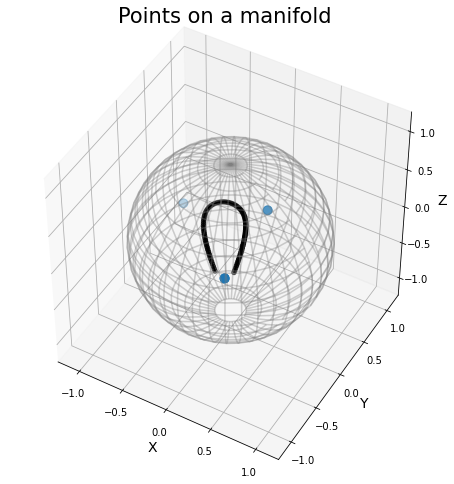

In [16]:
# Smaller lamda
lamda=10
curve = bezierCurve(manifold,dataPoints,dataCoords,t,lamda)
curvePoints = np.zeros((curve.shape[0],3))
for i in range(curve.shape[0]):
    curvePoints[i] = curve[i,:,:]
        
display(manifold, dataPoints, curvePoints)

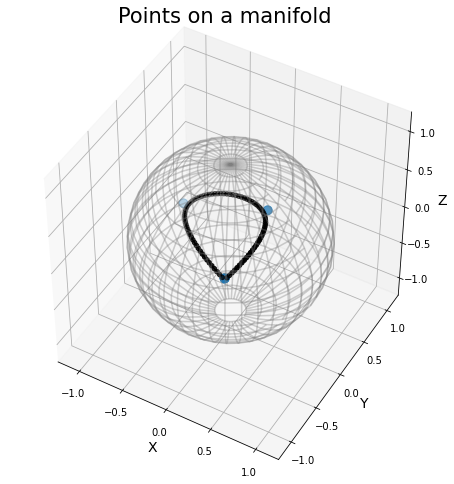

In [17]:
# Larger lamda
lamda=100
curve = bezierCurve(manifold,dataPoints,dataCoords,t,lamda)
curvePoints = np.zeros((curve.shape[0],3))
for i in range(curve.shape[0]):
    curvePoints[i] = curve[i,:,:]
        
display(manifold, dataPoints, curvePoints)
    

Very cool! As you can see the larger value of lambda = 100 give us a curve that fits the manifold data closer than when lamba = 10

## Zig Zag Points on the Sphere

In [52]:
# Set up the Data
dim = 2
sphere = Hypersphere(dim=dim)

points = np.array([[0.1,-0.2,0.1],
                  [-0.1,-0.25,0.4],
                  [0.25,-0.1,0.4],
                  [0.4,-0.2,0.1],
                  [0.25,0.1,0.4]])

# project points onto manifold
sphere_points = np.array([sphere.projection(points[0])])
for i in range(1,len(points)):
    sphere_points = np.append(sphere_points,[sphere.projection(points[i])],axis=0)
    

print(sphere_points)
manifold = sphere 
dataPoints = sphere_points
nData = len(dataPoints)
dataCoords = np.linspace(0,1,nData)
t = np.linspace(0, 1, (nData-1)*30)

[[ 0.40824829 -0.81649658  0.40824829]
 [-0.20739034 -0.51847585  0.82956136]
 [ 0.51847585 -0.20739034  0.82956136]
 [ 0.87287156 -0.43643578  0.21821789]
 [ 0.51847585  0.20739034  0.82956136]]


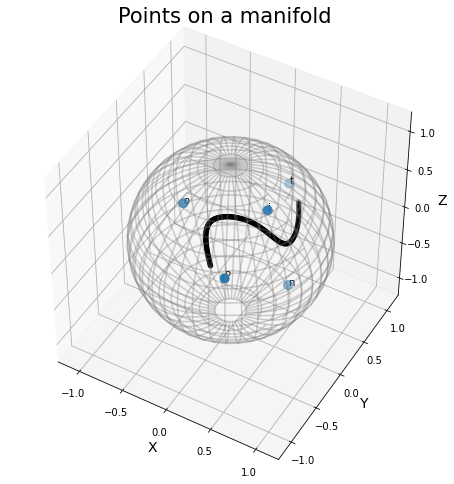

In [56]:
# Smaller lamda
lamda=5
curve = bezierCurve(manifold,dataPoints,dataCoords,t,lamda)
curvePoints = np.zeros((curve.shape[0],3))
for i in range(curve.shape[0]):
    curvePoints[i] = curve[i,:,:]
        
display(manifold, dataPoints, curvePoints)

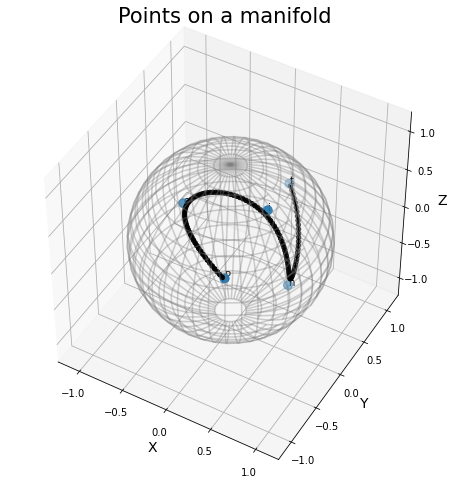

In [54]:
# Larger lamda
lamda=100
curve = bezierCurve(manifold,dataPoints,dataCoords,t,lamda)
curvePoints = np.zeros((curve.shape[0],3))
for i in range(curve.shape[0]):
    curvePoints[i] = curve[i,:,:]
        
display(manifold, dataPoints, curvePoints)

Again, you can see the order of the 5 points an how the curve tries to fit them. The smaller lambda = 5 indeed gives a "straighter" line whereas the larger lamba = 100 does a better job of actually touching the datapoints.

This conincides with the who point of this study where as you increase lamda, the cirve fitting formula using bezier curves begins to act like an interpolator of the data on the manifold.